# Improve the milestone tracking's flowtime

In [1]:
import sys
sys.path.append('../')
from panav.env import NavigationEnv, Box2DRegion, box_2d_center, PolygonRegion
from panav.hybrid import HybridGraph
from panav.viz import draw_hybrid

from panav.TrafficAwarePlanning import traffic_aware_HG_plan
from panav.SAMP import Tube_Planning

import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

## Empty environment

In [64]:

# 2D navigation environment

start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

top, bottom = 8,-8
start_x_offset = 6
goal_x_offset = 8
N = 5

start_locs = np.vstack([
np.vstack([np.ones(N)*start_x_offset,np.linspace(top,bottom, N)]).T,
np.vstack([np.ones(N)*(-start_x_offset),np.linspace(top,bottom, N)]).T])

goal_locs = np.vstack([
np.vstack([np.ones(N)*(-goal_x_offset),np.linspace(bottom,top, N)]).T,
np.vstack([np.ones(N)*goal_x_offset,np.linspace(bottom,top, N)]).T])


starts = [box_2d_center(s,start_box_side) for s in start_locs]
goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

# start = np.array(list(starts[0].centroid().coords)[0])
# goal = np.array(list(goals[0].centroid().coords)[0])

limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 
env = NavigationEnv(limits,[],starts,goals)

# Multi-tunnel Environment

In [65]:
y_min,y_max = min(limits[1]),max(limits[1])
n_tunnel = 6
w = 2*bloating_r # Tunnel width
s = (y_max-y_min-w*n_tunnel)/(n_tunnel+1) # Spacing between tunnels

d = 5 # Thickness of the wall

obstacles = []
for i in range(n_tunnel+1):
    side = np.array([d,s])
    center = np.array([0, y_max-s/2-i*(s+w)])
    obstacles.append(box_2d_center(center,side))
env.obstacles = obstacles



/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


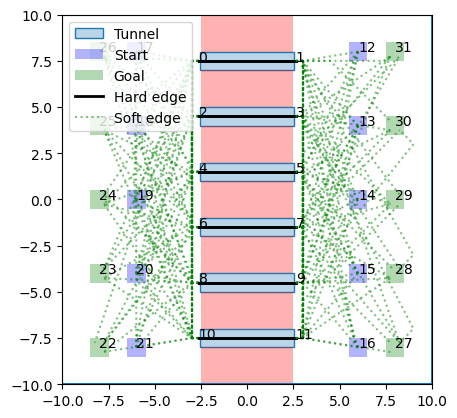

In [66]:
HG = HybridGraph(env,bloating_r)
ax = plt.gca()
draw_hybrid(HG,ax,display_soft=True,display_node=True)
plt.show()    


In [67]:
paths = traffic_aware_HG_plan(HG)

In [70]:
vmax = 1.0
continuous_plans = []

from panav.SAMP import Efficient_Tube_Planning,auto_K_tube_planning,milestone_tracking

for i,path in enumerate(paths):
    print("Planning for {}/{}".format(i,len(paths)))
    start = HG.node_loc(path[0])
    goal = HG.node_loc(path[-1])
    # milestones = [HG.node_loc(u) for u in path]
    # p = milestone_tracking(HG.env,milestones,continuous_plans,vmax,bloating_r)

    solver = Tube_Planning(HG.env,start,goal,vmax = vmax,bloating_r=bloating_r)
    # p = solver.plan(obstacle_trajectories=continuous_plans)
    p = solver.lazy_optim(obstacle_trajectories=continuous_plans)
    continuous_plans.append(p)


Planning for 0/10
Planning for 1/10
Planning for 2/10
Planning for 3/10
Planning for 4/10
Planning for 5/10
Planning for 6/10
Planning for 7/10
Planning for 8/10
Planning for 9/10


In [33]:
type(10)

int

In [44]:
from panav.SAMP_class.solvers import Tube_Planning

In [51]:
start = HG.node_loc(paths[0][0])
goal = HG.node_loc(paths[0][-1])
solver = Tube_Planning(HG.env,start,goal,vmax = vmax,bloating_r=bloating_r)

In [52]:
solver.plan()

(array([-0.     ,  9.19239, 17.67767, 30.75914]),
 array([[ 6.  ,  3.  , -3.  , -7.75],
        [ 8.  ,  1.5 ,  1.5 , -7.75]]))

In [53]:
solver.lazy_optim()

(array([-0.     ,  9.19239, 17.67767, 30.75914]),
 array([[ 6.  ,  3.  , -3.  , -7.75],
        [ 8.  ,  1.5 ,  1.5 , -7.75]]))

In [8]:

def flowtime(plan):
    return np.sum([t[-1] for t,x in plan])
def makespan(plan):
    return np.max([t[-1] for t,x in plan])

In [9]:
flowtime(continuous_plans)

521.0516640724189

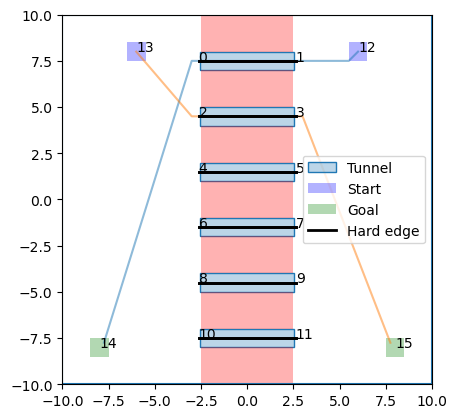

In [19]:
draw_hybrid(HG,ax=plt.gca(),paths = [o[1] for o in continuous_plans if o])

In [20]:
from panav.viz import animation,interpolate_positions

from IPython.display import HTML, display
interp_dt = 0.1

pos = []
for cp in continuous_plans:
    _,xs = interpolate_positions(*cp,interp_dt)
    pos.append(xs)

anim = animation(env, pos, bloating_r, dt = interp_dt / 4)
display(HTML(anim.to_jshtml()))
plt.close()   # Avoid plotting an extra figure.